#IMPORTING LIBRARIES REQUIRED

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import cv2
import PIL
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import warnings
warnings.filterwarnings(action="ignore")


from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google.colab import files
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#IMPORT KAGGLE DATASET

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to kaggle.json in Google Drive
kaggle_path = '/content/drive/My Drive/Keys/kaggle.json'  # Update this path as per your Drive structure

# Create the Kaggle directory and copy kaggle.json
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!cp "{kaggle_path}" /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Install Kaggle CLI
!pip install kaggle

# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the dataset
import zipfile
with zipfile.ZipFile("chest-xray-pneumonia.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")
print("Dataset extracted to /content/dataset")


Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:09<00:00, 268MB/s]
100% 2.29G/2.29G [00:09<00:00, 248MB/s]
Dataset extracted to /content/dataset


#CHECK OVERLAPPING

In [ ]:
import os
import hashlib

# Define dataset directories
train_dir = "/content/dataset/chest_xray/train"
val_dir = "/content/dataset/chest_xray/val"
test_dir = "/content/dataset/chest_xray/test"

# Function to calculate the hash of an image file
def calculate_file_hash(filepath):
    with open(filepath, 'rb') as f:
        file_hash = hashlib.md5(f.read()).hexdigest()  # You can also use SHA256 for stronger hashing
    return file_hash

# Collect hashes for all images in a directory
def get_hashes_and_files(directory):
    hashes = {}
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepath = os.path.join(root, file)
                file_hash = calculate_file_hash(filepath)
                if file_hash in hashes:
                    hashes[file_hash].append(filepath)
                else:
                    hashes[file_hash] = [filepath]
    return hashes

# Get image hashes for train, val, and test sets
train_hashes = get_hashes_and_files(train_dir)
val_hashes = get_hashes_and_files(val_dir)
test_hashes = get_hashes_and_files(test_dir)

# Find overlaps between sets
def find_overlaps(set1, set2):
    overlap = {}
    for hash_val, files in set1.items():
        if hash_val in set2:
            overlap[hash_val] = {'set1_files': files, 'set2_files': set2[hash_val]}
    return overlap

# Check for overlaps
train_val_overlap = find_overlaps(train_hashes, val_hashes)
train_test_overlap = find_overlaps(train_hashes, test_hashes)
val_test_overlap = find_overlaps(val_hashes, test_hashes)

# Print results
print("Overlaps between Train and Validation sets:", len(train_val_overlap))
print("Overlaps between Train and Test sets:", len(train_test_overlap))
print("Overlaps between Validation and Test sets:", len(val_test_overlap))

# If overlaps exist, print details
if train_val_overlap:
    print("Train-Validation Overlapping Files:")
    for hash_val, details in train_val_overlap.items():
        print(f"Hash: {hash_val}")
        print(f"Train files: {details['set1_files']}")
        print(f"Validation files: {details['set2_files']}\n")

if train_test_overlap:
    print("Train-Test Overlapping Files:")
    for hash_val, details in train_test_overlap.items():
        print(f"Hash: {hash_val}")
        print(f"Train files: {details['set1_files']}")
        print(f"Test files: {details['set2_files']}\n")

if val_test_overlap:
    print("Validation-Test Overlapping Files:")
    for hash_val, details in val_test_overlap.items():
        print(f"Hash: {hash_val}")
        print(f"Validation files: {details['set1_files']}")
        print(f"Test files: {details['set2_files']}\n")


Overlaps between Train and Validation sets: 0
Overlaps between Train and Test sets: 0
Overlaps between Validation and Test sets: 0


#OPEN SAMPLE IMAGE

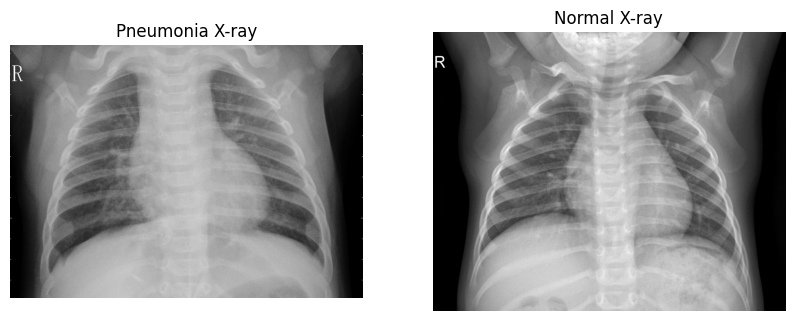

In [ ]:
# Load images
image_pneumonia = Image.open("/content/dataset/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg")
image_normal = Image.open("/content/dataset/chest_xray/train/NORMAL/IM-0119-0001.jpeg")

# Create a subplot with 1 row and 2 columns
plt.figure(figsize=(10, 5))

# Display pneumonia image
plt.subplot(1, 2, 1)
plt.imshow(image_pneumonia, cmap='gray')
plt.title('Pneumonia X-ray')
plt.axis('off')

# Display normal image
plt.subplot(1, 2, 2)
plt.imshow(image_normal, cmap='gray')
plt.title('Normal X-ray')
plt.axis('off')

# Show the images
plt.show()


#ORIGINAL DATASET COUNT

In [ ]:
import os

# Path to the original dataset
original_data_dir = '/content/dataset/chest_xray'

# Dataset types and categories
dataset_types = ['train', 'test', 'val']
categories = ['NORMAL', 'PNEUMONIA']

# Function to count images in a folder
def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# Count images in the original dataset
for dtype in dataset_types:
    for category in categories:
        # Count images in the original directory
        original_count = count_images_in_folder(os.path.join(original_data_dir, dtype, category))

        # Print count
        print(f"{dtype.capitalize()} - {category}:")
        print(f"  Original count: {original_count}")
        print()


Train - NORMAL:
  Original count: 1341

Train - PNEUMONIA:
  Original count: 3875

Test - NORMAL:
  Original count: 234

Test - PNEUMONIA:
  Original count: 390

Val - NORMAL:
  Original count: 8

Val - PNEUMONIA:
  Original count: 8



#SET UP PATH FOR TRAINING,TESTING AND VALIDATION DIRECTORY.

In [ ]:
# Dataset Paths
healthy_dirs = [
    r'/content/dataset/chest_xray/test/NORMAL',
    r'/content/dataset/chest_xray/train/NORMAL',
    r'/content/dataset/chest_xray/val/NORMAL',
]

pneumonia_dirs = [
    r'/content/dataset/chest_xray/test/PNEUMONIA',
    r'/content/dataset/chest_xray/train/PNEUMONIA',
    r'/content/dataset/chest_xray/val/PNEUMONIA'
]

filepaths, labels = [], []
dict_lists = [healthy_dirs, pneumonia_dirs]
class_labels = ['Normal', 'Pneumonia']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            filepaths.append(os.path.join(j, f))
            labels.append(class_labels[i])

pneumonia_df = pd.DataFrame({"filepaths": filepaths, "labels": labels})
print(pneumonia_df.head())
print(pneumonia_df["labels"].value_counts())

# Train, Test, Validation Splits
train_set, test_set = train_test_split(pneumonia_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(train_set, test_size=0.2, random_state=42)

                                           filepaths  labels
0  /content/dataset/chest_xray/test/NORMAL/NORMAL...  Normal
1  /content/dataset/chest_xray/test/NORMAL/NORMAL...  Normal
2  /content/dataset/chest_xray/test/NORMAL/NORMAL...  Normal
3  /content/dataset/chest_xray/test/NORMAL/NORMAL...  Normal
4  /content/dataset/chest_xray/test/NORMAL/NORMAL...  Normal
labels
Pneumonia    4273
Normal       1583
Name: count, dtype: int64


#DATA AUGMENTATION

In [ ]:
# Data Augmentation and Loading
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_gen = image_gen.flow_from_dataframe(
    dataframe=train_set, x_col="filepaths", y_col="labels",
    target_size=(244, 244), class_mode="categorical", batch_size=4, shuffle=True
)
val_gen = image_gen.flow_from_dataframe(
    dataframe=val_set, x_col="filepaths", y_col="labels",
    target_size=(244, 244), class_mode="categorical", batch_size=4, shuffle=False
)
test_gen = image_gen.flow_from_dataframe(
    dataframe=test_set, x_col="filepaths", y_col="labels",
    target_size=(244, 244), class_mode="categorical", batch_size=4, shuffle=False
)

classes = list(train_gen.class_indices.keys())
print("Classes:", classes)

Found 3279 validated image filenames belonging to 2 classes.
Found 820 validated image filenames belonging to 2 classes.
Found 1757 validated image filenames belonging to 2 classes.
Classes: ['Normal', 'Pneumonia']


#CNN MODEL

In [ ]:
from tensorflow.keras.layers import MaxPooling2D
# Define the Model
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),


    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256,activation = "relu"),
    Dropout(0.3),
    Dense(128,activation = "relu"),
    Dropout(0.3),
    Dense(class_count, activation = "softmax")
])

#model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,514 (30.61 MB)

 Trainable params: 8,024,514 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

#SGD TO ADAMAX

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])


# Training the Model
history = model.fit(train_gen, epochs=10, validation_data=val_gen, verbose=1)


Epoch 1/10
820/820 ━━━━━━━━━━━━━━━━━━━━ 65s 57ms/step - accuracy: 0.7994 - loss: 0.4589 - val_accuracy: 0.9415 - val_loss: 0.1528
Epoch 2/10
820/820 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.9517 - loss: 0.1407 - val_accuracy: 0.9598 - val_loss: 0.1080
Epoch 3/10
820/820 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9574 - loss: 0.1129 - val_accuracy: 0.9537 - val_loss: 0.1284
Epoch 4/10
820/820 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9660 - loss: 0.0915 - val_accuracy: 0.9671 - val_loss: 0.0921
Epoch 5/10
820/820 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9711 - loss: 0.0767 - val_accuracy: 0.9671 - val_loss: 0.1159
Epoch 6/10
820/820 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - accuracy: 0.9766 - loss: 0.0705 - val_accuracy: 0.9695 - val_loss: 0.0881
Epoch 7/10
820/820 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.9831 - loss: 0.0499 - val_accuracy: 0.9585 - val_loss: 0.1407
Epoch 8/10
820/820 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.9868 - loss: 0.0361 - 

#Code to Plot Accuracy and Loss Curves

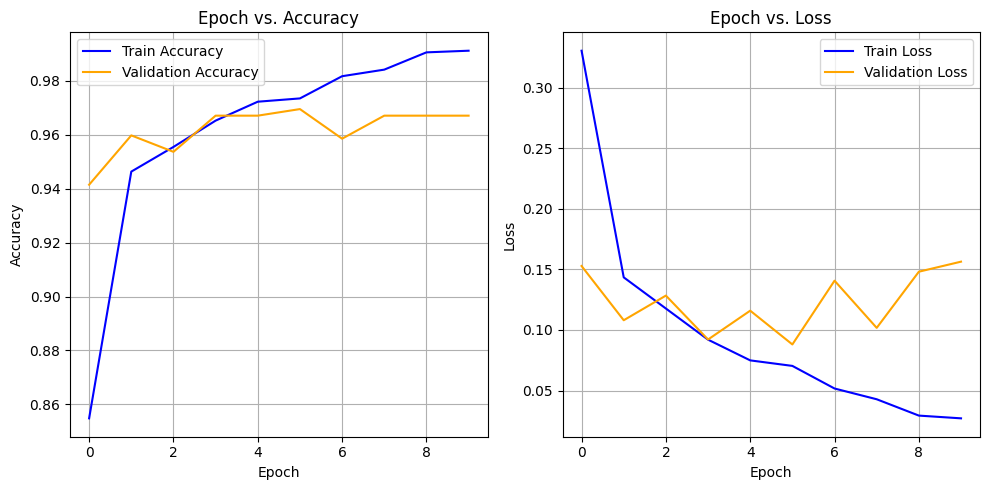

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable that holds the output of model.fit()
# History contains 'accuracy', 'loss', 'val_accuracy', and 'val_loss'

# Plotting Accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Epoch vs. Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Epoch vs. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



#MODEL TESTING

In [ ]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

440/440 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9591 - loss: 0.1653
Test Accuracy: 0.96


#EVALUATION METRICS

440/440 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step


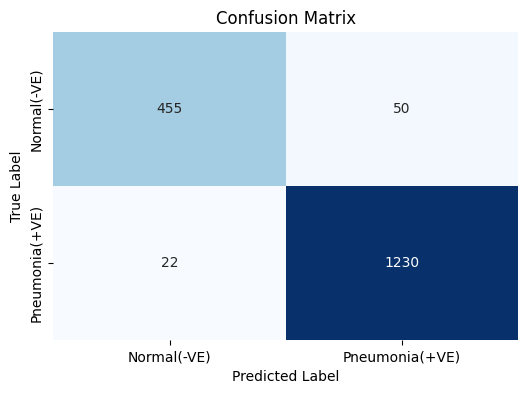

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       505
           1       0.96      0.98      0.97      1252

    accuracy                           0.96      1757
   macro avg       0.96      0.94      0.95      1757
weighted avg       0.96      0.96      0.96      1757

AUC: 0.9874


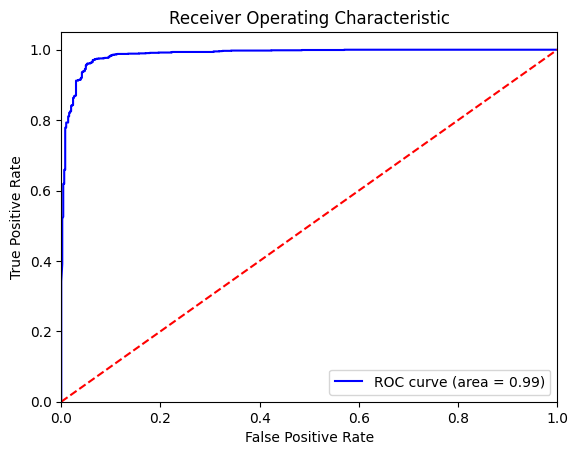

Log Loss: 0.2025
This is the final metrics table (0 = Normal, 1 = Pneumonia):


,Metric,Value
0,True Negatives,455.000000
1,False Positives,50.000000
2,False Negatives,22.000000
3,True Positives,1230.000000
4,Accuracy,0.959021
5,Precision (0),0.953878
6,Precision (1),0.960938
7,Recall (0),0.900990
8,Recall (1),0.982428
9,F1 Score (0),0.926680


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, log_loss

# Assuming 'data_test' is the test data generator from the previous code
# Make predictions on the test data
y_pred = model.predict(test_gen, verbose=1)  # Get predictions

# Convert probabilities to binary predictions (for classification)
y_pred_classes = np.argmax(y_pred, axis=1)  # Use argmax to get the predicted class index

# Retrieve true labels from the test generator
y_true = test_gen.classes  # True labels
y_true = np.array(y_true)  # Convert to numpy array

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix with labels
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal(-VE)', 'Pneumonia(+VE)'],
            yticklabels=['Normal(-VE)', 'Pneumonia(+VE)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))
classification_report_dict = classification_report(y_true, y_pred_classes, output_dict=True)

# Calculate and plot AUC-ROC
# Calculate ROC curve (use the raw predicted probabilities)
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])  # Get probabilities for the positive class (index 1)

# Calculate AUC
auc_score = auc(fpr, tpr)
print(f"AUC: {auc_score:.4f}")

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Calculate Log Loss (use the raw predicted probabilities)
log_loss_value = log_loss(y_true, y_pred)
print(f"Log Loss: {log_loss_value:.4f}")

# Extract confusion matrix values
tn, fp, fn, tp = cm.ravel()  # tn=true negatives, fp=false positives, fn=false negatives, tp=true positives

# Prepare final values in a DataFrame
final_metrics = {
    'Metric': [
        'True Negatives',
        'False Positives',
        'False Negatives',
        'True Positives',
        'Accuracy',
        'Precision (0)',
        'Precision (1)',
        'Recall (0)',
        'Recall (1)',
        'F1 Score (0)',
        'F1 Score (1)',
        'AUC',
        'Log Loss'
    ],
    'Value': [
        tn,
        fp,
        fn,
        tp,
        classification_report_dict['accuracy'],
        classification_report_dict['0']['precision'],
        classification_report_dict['1']['precision'],
        classification_report_dict['0']['recall'],
        classification_report_dict['1']['recall'],
        classification_report_dict['0']['f1-score'],
        classification_report_dict['1']['f1-score'],
        auc_score,
        log_loss_value
    ]
}

# Create a DataFrame for the final metrics
final_metrics_df = pd.DataFrame(final_metrics)

# Print clarification and the final metrics table with styling
print("This is the final metrics table (0 = Normal, 1 = Pneumonia):")
styled_table = final_metrics_df.style.set_table_attributes('style="font-size: 14px; margin: 20px; border-collapse: collapse;"') \
                                       .set_caption("Final Metrics Table") \
                                       .set_table_styles([{'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white')]},
                                                          {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('padding', '8px')]},
                                                          {'selector': 'tr:hover', 'props': [('background-color', '#f1f1f1')]}]) \
                                       #.highlight_max(axis=0, color='lightgreen')

# Display the styled DataFrame
styled_table


#TEST TRY

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


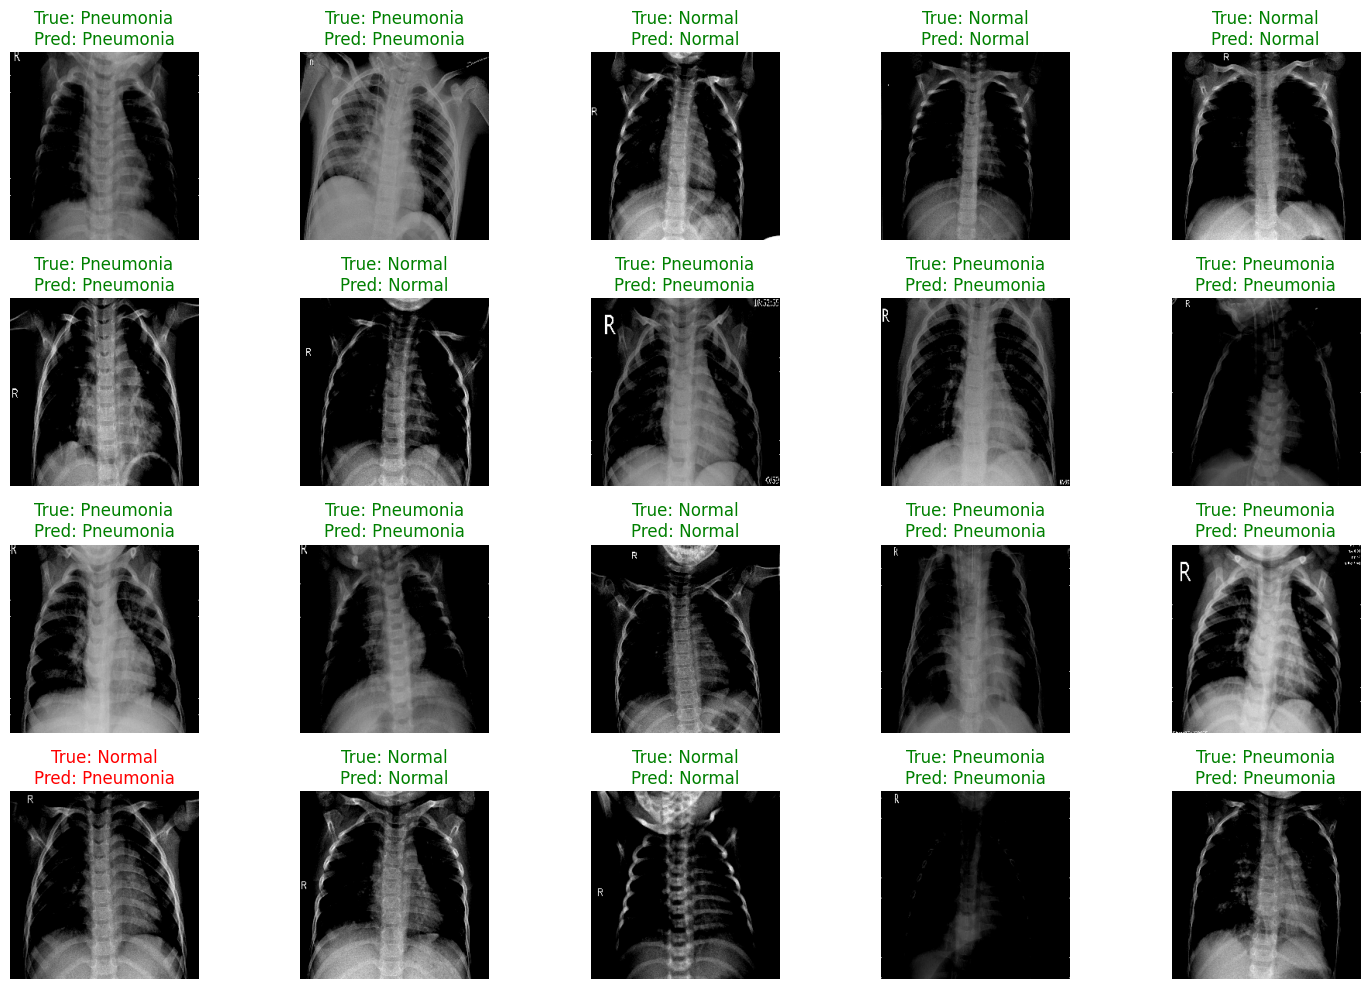

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to display images with actual and predicted labels and color coding
def display_images_with_predictions(test_gen, model, num_images=20):
    # Create a list to store images, true labels, and predicted labels
    images = []
    true_labels = []
    pred_labels = []

    # Loop through the test set and collect enough images
    count = 0
    for batch_x, batch_y in test_gen:
        # Predict for the current batch
        y_pred = model.predict(batch_x)

        # Convert predictions to class labels
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Get the true labels (index of class)
        y_true = np.argmax(batch_y, axis=1)

        # Append the images and labels to the list
        for i in range(len(batch_x)):
            images.append(batch_x[i])
            true_labels.append(y_true[i])
            pred_labels.append(y_pred_classes[i])
            count += 1
            if count >= num_images:
                break

        if count >= num_images:
            break

    # Create the plot with the collected images
    plt.figure(figsize=(15, 10))  # Increase figure size to fit more images
    for i in range(num_images):
        plt.subplot(4, 5, i+1)  # Layout with 4 rows and 5 columns
        plt.imshow(images[i])

        # Get the true and predicted class labels
        true_label = 'Normal' if true_labels[i] == 0 else 'Pneumonia'
        pred_label = 'Normal' if pred_labels[i] == 0 else 'Pneumonia'

        # Set color based on whether prediction is correct or incorrect
        if true_labels[i] == pred_labels[i]:
            color = 'green'  # Correct prediction
        else:
            color = 'red'  # Incorrect prediction

        # Display the image with the true and predicted labels
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display 20 images from the test set with actual and predicted classes
display_images_with_predictions(test_gen, model, num_images=20)


#Save the model

In [ ]:
# # Save in HDF5 format
# model_densenet.save("/content/saved_model_densenet.h5")

# Save the model in the recommended Keras format
model.save("/content/saved_model_densenet.keras")